Top 5 performing stocks: ['NVDA', 'LLY', 'XOM', 'CVX', 'TSLA']
Epoch 1/30
18/18 [==============================] - 7s 5ms/step - loss: 0.0308
Epoch 2/30
18/18 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 3/30
18/18 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 4/30
18/18 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 5/30
18/18 [==============================] - 0s 4ms/step - loss: 9.7753e-04
Epoch 6/30
18/18 [==============================] - 0s 4ms/step - loss: 9.6587e-04
Epoch 7/30
18/18 [==============================] - 0s 4ms/step - loss: 9.2514e-04
Epoch 8/30
18/18 [==============================] - 0s 4ms/step - loss: 9.1788e-04
Epoch 9/30
18/18 [==============================] - 0s 4ms/step - loss: 9.4192e-04
Epoch 10/30
18/18 [==============================] - 0s 4ms/step - loss: 9.2887e-04
Epoch 11/30
18/18 [==============================] - 0s 4ms/step - loss: 8.9214e-04
Epoch 12/30
18/18 [===================

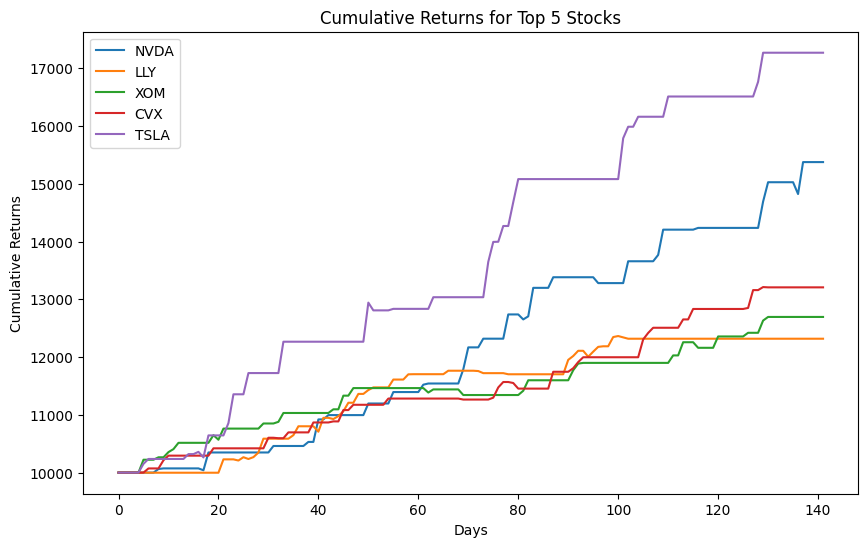

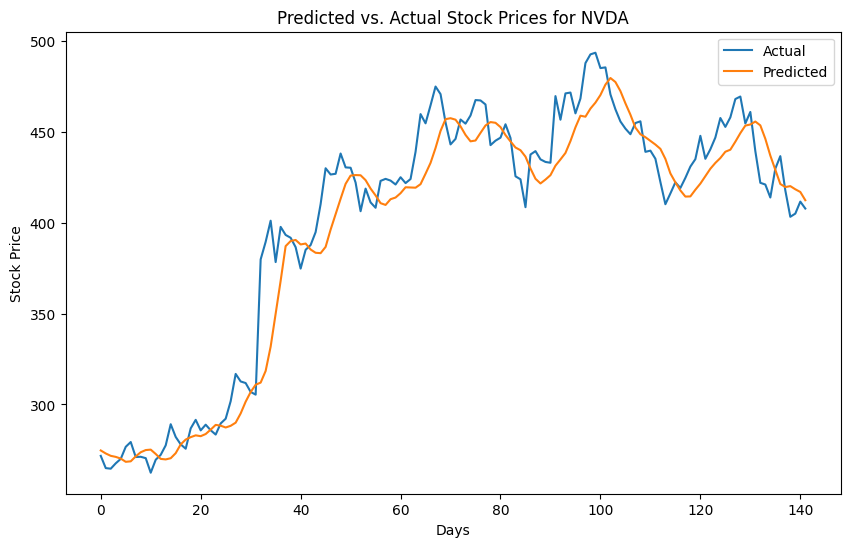

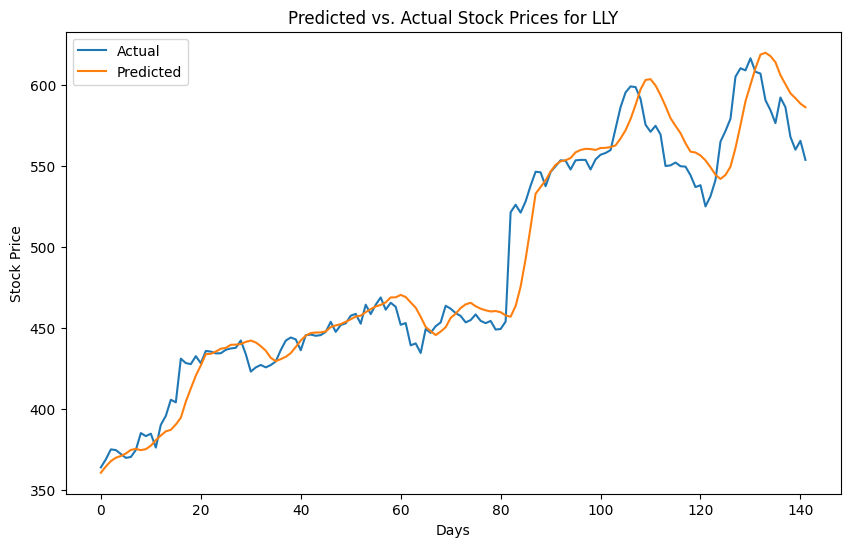

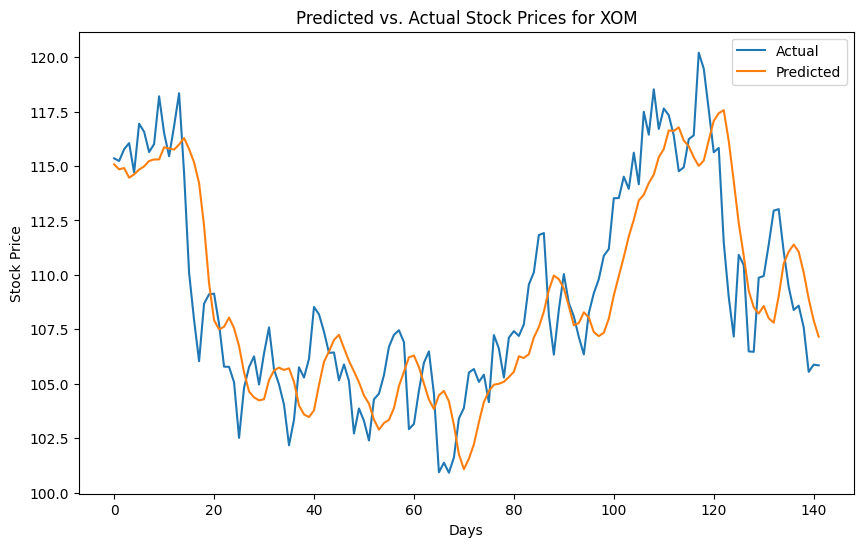

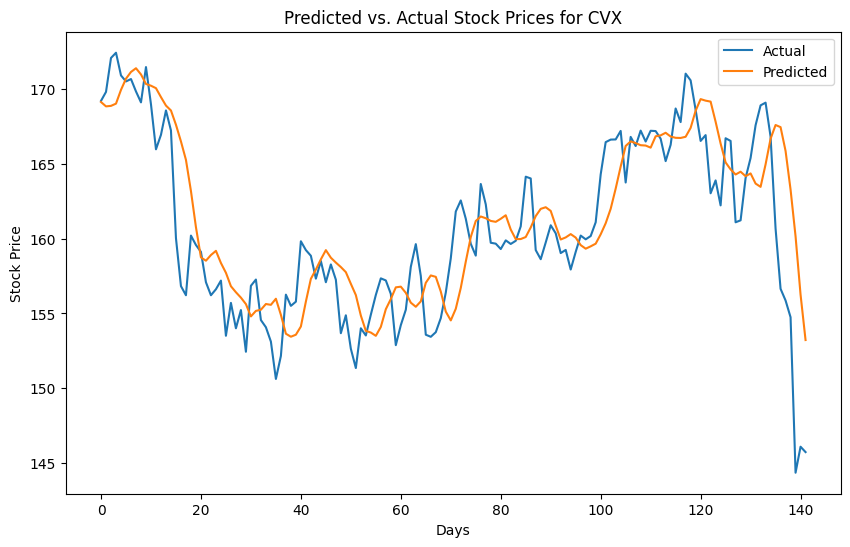

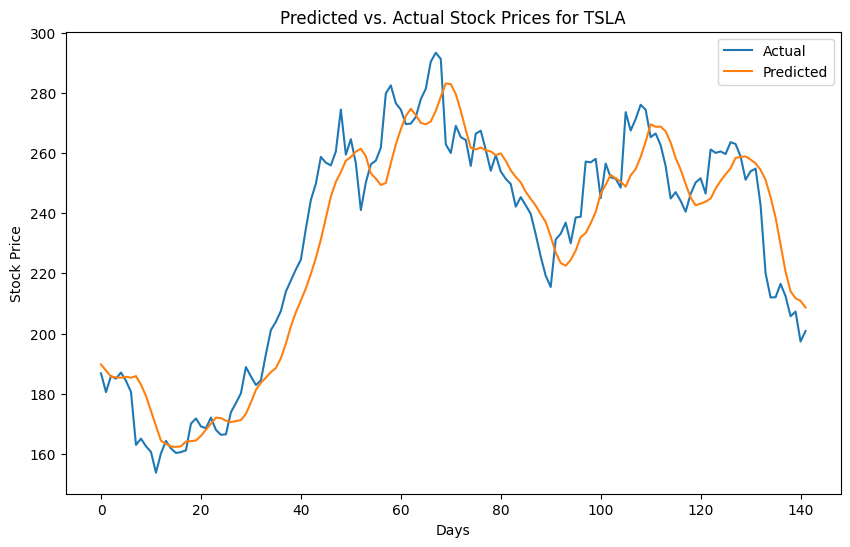

In [1]:

import numpy as np
import pandas as pd
from collections import deque
import random
import yfinance as yf
import matplotlib.pyplot as plt

# Import MinMaxScaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

# Import Sequential and LSTM from TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout  # Add LSTM here


# Fetch Dow Jones 30 stocks and preprocess data

def fetch_data(tickers):
    data = {}
    for ticker in tickers:
        stock_data = yf.download(ticker, start="2021-01-01", end="2023-11-01", progress=False)
        stock_data['Return'] = stock_data['Close'].pct_change()
        data[ticker] = stock_data.dropna()
    return data

tickers = ['LLY', 'XOM', 'TSLA', 'NVDA', 'CVX']

data = fetch_data(tickers)

# Sort by performance and pick the top 5
sorted_tickers = sorted(tickers, key=lambda x: data[x]['Return'].sum(), reverse=True)[:5]
print("Top 5 performing stocks:", sorted_tickers)

# Initialize a dictionary to store cumulative returns and predicted versus actual results
cumulative_returns_dict = {}
predicted_vs_actual_dict = {}

# Iterate over the top 5 performing stocks
for ticker in sorted_tickers:
    # LSTM Model for the stock
    df = data[ticker].copy()
    df.dropna(inplace=True)

    # Scaling and reshaping for LSTM
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Close']].values)

    X, y = [], []
    for i in range(5, len(scaled_data)):
        X.append(scaled_data[i-5:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data
    train_size = int(0.8 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=30, batch_size=32)

    # Predictions
    predicted = model.predict(X_test)
    predicted = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    df['Predicted'] = np.nan
    df.iloc[-len(predicted):, df.columns.get_loc('Predicted')] = predicted

    # Trading Strategy
    test = df[-len(predicted):].copy()
    test['Position'] = np.where(test['Predicted'] > test['Open'], 1, -1)

    # Calculate 5-day percentage change for test data
    test['5_Day_Pct_Change'] = test['Close'].pct_change(periods=5)

    # Portfolio variables
    initial_balance = 10000.00
    balance = initial_balance

    # Track cumulative returns
    cumulative_returns = []

    # Trading logic for each test day
    for idx, row in test.iterrows():
        predicted_close = row['Predicted']
        actual_close = row['Close']
        open_price = row['Open']
        five_day_pct_change = row['5_Day_Pct_Change']

        if predicted_close > open_price and five_day_pct_change > 0:
            if actual_close > open_price:
                balance += (actual_close - open_price) * (balance / open_price)
            else:
                balance -= (open_price - actual_close) * (balance / open_price)
        elif predicted_close < open_price and five_day_pct_change < 0:
            if actual_close < open_price:
                balance += (open_price - actual_close) * (balance / open_price)
            else:
                balance -= (actual_close - open_price) * (balance / open_price)

        cumulative_returns.append(balance)

    # Store cumulative returns and predicted versus actual results
    cumulative_returns_dict[ticker] = cumulative_returns
    predicted_vs_actual_dict[ticker] = (predicted, actual)

# Plot cumulative returns for each stock
plt.figure(figsize=(10, 6))
for ticker, returns in cumulative_returns_dict.items():
    plt.plot(returns, label=ticker)

plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns for Top 5 Stocks")
plt.legend()
plt.show()

# Plot predicted versus actual results for each stock
for ticker, (predicted, actual) in predicted_vs_actual_dict.items():
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label="Actual")
    plt.plot(predicted, label="Predicted")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.title(f"Predicted vs. Actual Stock Prices for {ticker}")
    plt.legend()
    plt.show()


Upon reviewing the provided code, it seems that while LSTM models are built and used for predicting stock prices, their interaction with Reinforcement Learning (RL) specifically within a DQN framework is not clearly established in the code.

Here's an analysis of the two key components and their functions in the code:
LSTM for Stock Price Prediction

    Functionality: LSTM models are trained for each stock to predict future closing prices. The code processes historical stock data, scales it, and feeds it into LSTM models for training. Predictions are made based on these trained models.
    Use in Trading Strategy: The code uses the LSTM model's predictions in a simple trading strategy. It decides to buy if the predicted next closing price is higher than the current opening price and sell if it's lower. This decision-making process is, however, not integrated into the DQN framework.

DQN for Decision Making

    The code includes a class DQNAgent, which is a typical setup for a Deep Q-Network agent. This agent is designed to learn the best action to take in a given state to maximize cumulative rewards.
    Model Architecture: The agent uses a neural network (defined in _build_model) to estimate the Q-values for each action given a state.
    Training Mechanism: The agent's memory and the replay method suggest it is set up to learn from experiences (state, action, reward, next state) via experience replay.

Missing Integration

    The LSTM predictions are used in a standalone trading strategy and are not directly influencing the actions of the DQN agent.
    The DQN agent seems to be set up for a typical RL environment, but there is no clear integration where the LSTM's output (predicted stock prices) directly influences the agent's decision-making process.

How to Integrate LSTM with DQN in Trading:

    State Incorporation: Integrate the LSTM's predictions into the state representation for the DQN agent. Each state provided to the DQN agent should include features derived from the LSTM predictions.
    Action Decision: The DQN agent should decide actions (buy, sell, hold) based on these states.
    Reward Mechanism: The reward mechanism should align with the trading goals, taking into account the accuracy of the LSTM's predictions and the profitability of the actions taken by the agent.

Conclusion

In the current form, the LSTM and DQN components operate separately within the code: LSTM for price prediction and a simple rule-based strategy for trading. For a true integration, the LSTM's output needs to be part of the state for the DQN agent, influencing its learning and decision-making process in a cohesive RL environment.

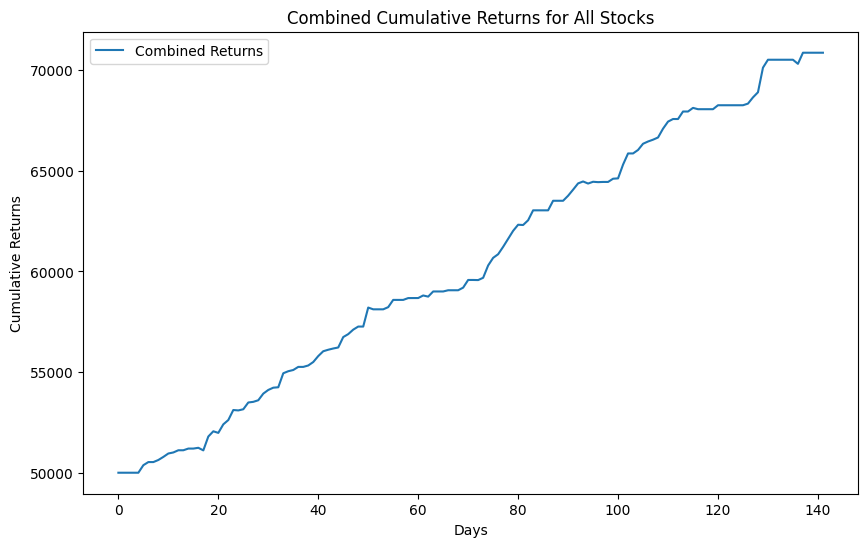

In [2]:
# Assuming 'cumulative_returns_dict' contains the cumulative returns for each stock

# Initialize a list to hold the combined cumulative returns
combined_cumulative_returns = []

# Get the number of days (or data points) for the cumulative returns
num_days = min(len(returns) for returns in cumulative_returns_dict.values())

# Calculate combined returns at each time point
for i in range(num_days):
    combined_return_at_i = sum(returns[i] for returns in cumulative_returns_dict.values())
    combined_cumulative_returns.append(combined_return_at_i)

# Plot combined cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(combined_cumulative_returns, label="Combined Returns")

plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.title("Combined Cumulative Returns for All Stocks")
plt.legend()
plt.show()
